In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.signal import convolve, fftconvolve
import scipy.signal

#import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops
#from skimage import data

# %load_ext autoreload
# %autoreload 2

# from src.datasets import generate_random_binary_array_with_squares, generate_random_array_with_correlated_noise, generate_two_dim_sin_cos_wave
# from src.aggregation_functions import agg_function

In [13]:
def noisy_pattern(shape, correlation_scale):
    '''
    Generate a random array with spatially correlated noise. The noise is generated by convolving a random array with a Gaussian kernel.
    Finally, the noise is normalized to [0, 1].

    args:
        shape: tuple or int, size of the array
        correlation_scale: float, scale of the Gaussian kernel
    '''
    if isinstance(shape, int):
        shape = (shape, shape)


    x = np.arange(-correlation_scale, correlation_scale+1)
    y = np.arange(-correlation_scale, correlation_scale+1)
    X, Y = np.meshgrid(x, y)
    #dist = np.sqrt(X*X + Y*Y)
    #filter_kernel = np.exp(-dist**2/(2*correlation_scale**2))
    #filter_kernel = (1/(correlation_scale**2))*np.exp(-dist**2/(2*correlation_scale**2))
    #filter_kernel = np.exp(-dist**2/(2*correlation_scale))

    dist = X*X + Y*Y
    sigma = correlation_scale/4
    norm_factor  = 2*np.pi*(sigma**2)
    filter_kernel = (1/norm_factor)*np.exp(-(dist)/(2*(sigma**2)))
   # print(np.sum(filter_kernel))

    noise = np.random.rand(*shape)
    noise = fftconvolve(noise, filter_kernel, mode='same')
    #noise = (noise-np.min(noise))/(np.max(noise)-np.min(noise))

    return noise

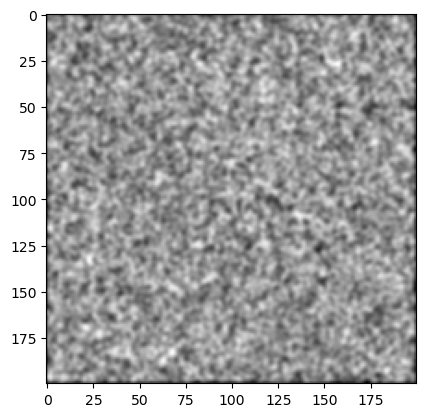

In [14]:
data = noisy_pattern(200, 5)
plt.imshow(data, cmap='gray')


# Moran's I


$I = \frac{N}{W} \frac{\sum_{i=1}^N\sum_{j=1}^Nw_{ij}(x_i-\bar{x})(x_k-\bar{x})}{\sum_{i=1}(x_i-\bar{x})^2}$

where $x_i$ is the variable of interest (e.g uncertainty) and $\bar{x}$ is the average of the $x_i$. $w_{ij}$ are the elements of a weights matrix with $w_{ii} = 0$. $N$ is the size of the matrix and $W=\sum_{i,j=0}^Nw_{ij}$. 

The value of $I$ is influenced by the choise of the weightmatrix $W$.

In [20]:
def morans_i(X, W):
    '''
    # generated by copilot
    Compute Moran's I for a given array X and a given weight matrix W.

    args:
        X: 2D numpy array, input array
        W: 2D numpy array, weight matrix
    '''
    n = X.size
    mean_X = np.mean(X)
    X = X - mean_X
    W_sum = np.sum(W)
    
    num = np.sum(W * (X[:, None, :] * X[None, :, :]))
    denom = np.sum(X**2)
    
    I = (n / W_sum) * (num / denom)
    return I

# Example usage
data = noisy_pattern(200, 2)
W = np.eye(data.shape[0], k=1) + np.eye(data.shape[0], k=-1)
I = morans_i(data, W)
print(I)

1.1906280841297952


# Garies C

 $
 C = \frac{(N-1)\sum_i\sum_jw_{ij}(x_i-x_j)^2}{2S_0\sum_i(x-\bar{x})^2}
 $

Geary's C is inversely related to Moran's I, but it is not identical. While Moran's I and Geary's C are both measures of global spatial autocorrelation, they are slightly different. Geary's C uses the sum of squared distances whereas Moran's I uses standardized spatial covariance. By using squared distances Geary's C is less sensitive to linear associations and may pickup autocorrelation where Moran's I may not. [from wikipedia](https://en.wikipedia.org/wiki/Geary%27s_C)

In [21]:
def gearys_c(X, W):
    '''
    Compute Geary's C for a given array X and a given weight matrix W.

    args:
        X: 2D numpy array, input array
        W: 2D numpy array, weight matrix
    '''
    n = X.size
    mean_X = np.mean(X)
    
    W_sum = np.sum(W)
    
    num = np.sum(W * (X[:, None, :] - X[None, :, :])**2)
    X = X - mean_X
    denom = 2 * np.sum(X**2)
    
    C = (n - 1) / W_sum * (num / denom)
    return C

# Example usage
C = gearys_c(data, W)
print(C)

193.09850801356802


# GLCM: Gray Level Co-ocurrence matrix

Designed to quantify texture

A gray level co-occurrence matrix is a histogram of co-occurring grayscale values at a given offset over an image.
The gray-level co-occurrence histogram. The value P[i,j,d,theta] is the number of times that gray-level j occurs at a distance d and at an angle theta from gray-level i. If normed is False, the output is of type uint32, otherwise it is float64. The dimensions are: levels x levels x number of distances x number of angles. [source: skimage](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.graycomatrix) [orginal publication](https://ieeexplore.ieee.org/document/4309314)

In [22]:
data = noisy_pattern(200, 110)

data = (data*255).astype(np.uint8)

gcm = graycomatrix(data, [1], [0], levels=256, symmetric=True, normed=True)
contrast = graycoprops(gcm, prop='contrast')
dissimilarity = graycoprops(gcm, prop='dissimilarity')
homogeneity = graycoprops(gcm, prop='homogeneity')
energy = graycoprops(gcm, prop='energy')
correlation = graycoprops(gcm, prop='correlation')

print(contrast, dissimilarity, homogeneity, energy, correlation)

0.9998828156867037
[[0.78188442]] [[0.55660804]] [[0.74422362]] [[0.12669773]] [[0.99922558]]


In [16]:
contrast


array([[89.50590452]])

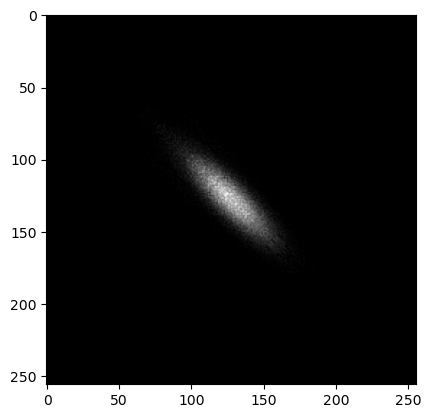

In [14]:
plt.imshow(gcm[:, :, 0, 0], cmap='gray')

Text(0.5, 1.0, '0.9999527872397467')

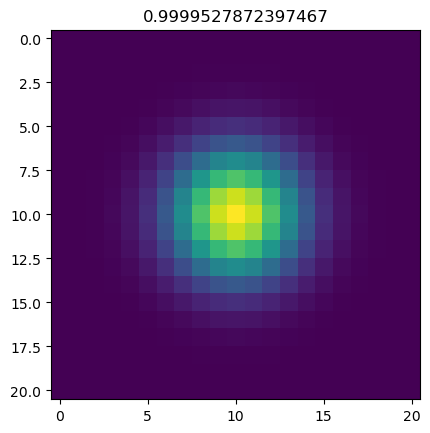

In [3]:
correlation_scale=10
x = np.arange(-correlation_scale, correlation_scale+1)
y = np.arange(-correlation_scale, correlation_scale+1)
X, Y = np.meshgrid(x, y)
dist = X*X + Y*Y
#filter_kernel = np.exp(-dist**2/(2*correlation_scale**2))
sigma = correlation_scale/4
norm_factor  = 2*np.pi*(sigma**2)
filter_kernel = (1/norm_factor)*np.exp(-(dist)/(2*(sigma**2)))
#filter_kernel = np.exp(-dist**2/(2*correlation_scale))

plt.imshow(filter_kernel)
plt.title(np.sum(filter_kernel))

In [128]:

array_size = 50
corr_scales = [1, 2, 5]

data_list = [noisy_pattern(array_size, cs) for cs in corr_scales]
corr_list = [scipy.signal.correlate(data, data) for data in data_list]
psd_list = [np.abs(np.fft.fftshift(np.fft.fft2(corr))) for corr in corr_list]

0.7794836797093876
0.6296536629370783
0.5321240617770989


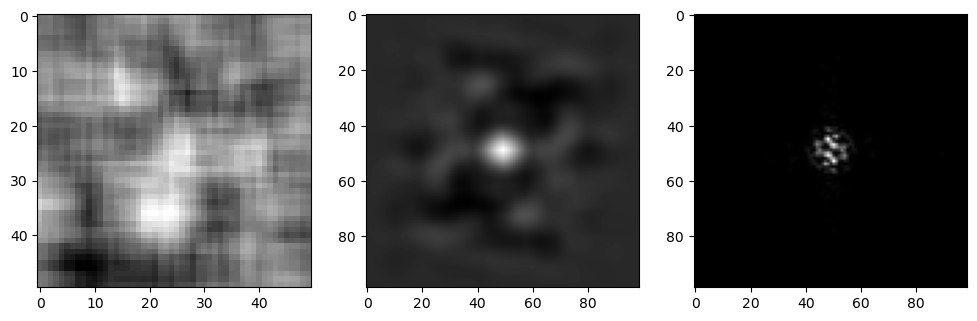

In [130]:

IDX = 2

plt.figure(figsize=(12, 6))

plt.subplot(1,3,1)
plt.imshow(data_list[IDX], cmap='gray')
#plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(corr_list[IDX], cmap='gray')
#plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(psd_list[IDX], cmap='gray')
#plt.axis("off")

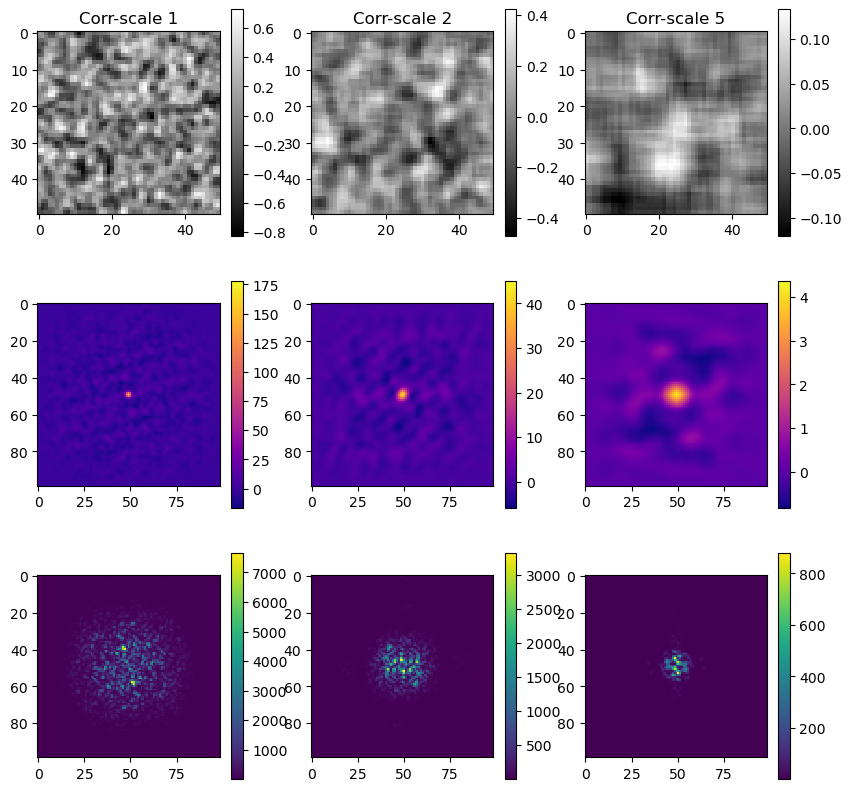

In [133]:
plt.figure(figsize=(10,10))

for i in range(len(data_list)):

    plt.subplot(3, 3, i+1)
    plt.imshow(data_list[i], cmap='grey', interpolation='none')
    plt.title(f"Corr-scale {corr_scales[i]}")
    plt.colorbar()

    

    plt.subplot(3, 3, i+4)
    plt.imshow(corr_list[i], cmap='plasma', interpolation='none')
    plt.colorbar()


    plt.subplot(3, 3, i+7)
    plt.imshow(psd_list[i], cmap='viridis', interpolation='none')
    plt.colorbar()


plt.show()